The process can be defined from ($\varphi, \lambda, Q$) where
* $\varphi$ is the ODE dynamics - or the integral path defined by a vector field $\Phi$
* $\lambda$ is the probability that a jumps occurs during the particle's movement
* $Q$ is the Markov kernel used for the jump

ZigZag sampler:

* $\Phi(x, v)$ = v
* $\lambda(x, v)_i = (v_i (\partial \psi(x))_i)_+$, with $\pi \propto \exp(-\psi(x))$ the target distribution. For Gaussian distribution: $$\lambda(x, v)_i = (v_i x_i)_+ $$
* Q reverses speed.

For the reverse process, we essentially just need to compute, for all $i$:
$$ \bar \lambda_i = \lambda_i \dfrac{p_t(x_t, R_i v_t)}{p_t(x_t, v_t)} $$
Notations:
$$ s_{\theta}(x, R v, t) = \begin{pmatrix} s_{\theta}(x, R_1 v, t)_1 \\ \cdots \\ s_{\theta}(x, R_d v, t)_d \end{pmatrix}$$
where $R_i v = \begin{pmatrix} v_1 \\ \cdot \\ -v_i \\ \cdot \\ v_n \end{pmatrix}$
* Fit the model by minimizing:
     $$ \mathbb{E}_{t, x, v} \|  s_{\theta}(x, v, t) - \dfrac{p_t(x_t, R v_t)}{p_t(x_t, v_t)}\|^2 =  \mathbb{E}_{t, x, v} \frac12 s_{\theta}(x, v, t)^2 - s_{\theta}(x, R v, t)$$



Current Limitations
* If the dimension is $d$, we need $d+1$ forward pass, because:
$$ \mathbb{E}_{t, x, v} \frac12 s_{\theta}(x, v, t)^2 - s_{\theta}(x, R v, t) = \mathbb{E}_{t, x, v} \sum_{i=1}^d \frac12 s_{\theta}(x, v, t)_i^2 - s_{\theta}(x, R_i v, t)_i$$
* The loss is unstable.

**Symmetrised ratio matching** we introduce the function $g(r) = \frac{1}{1+r}$ and define the objective function
\begin{equation}
    J_{ERM}(\theta) = \sum_{i=1}^d \mathbb{E}_{p_t}\left[ \left(g(s_\theta(X_t,V_t,t)[i]) - g(r_i(X_t,V_t,t)) \right)^2 + \left(g(s_\theta(X_t,R_iV_t,t)[i]) - g(r_i(X_t,R_iV_t,t)) \right)^2 \right]
\end{equation}
which is equivalent, as an objective function, to:
\begin{equation}
    J_{IRM}(\theta) = \sum_{i=1}^d \mathbb{E}_{p_t}\left[ \frac{1}{(1 + s_\theta(x,v,t)[i])^2} +\frac{1}{(1 + s_\theta(x,R_i v,t)[i])^2}  - \frac{2}{1 + s_\theta(x,v,t)[i]}\right]
\end{equation}


**KL minimisation** Focus on the score entropy:
\begin{equation}
    J_{ERM}(\theta) =  \sum_{i=1}^d w_i\mathbb{E}_{p_t}\left[ s_\theta(X_t,V_t,t)[i] -r_i(X_t,V_t,t)  - \Big( \log s_\theta(X_t,R_iV_t,t)[i]) - \log r_i(X_t,R_iV_t,t)\Big) \right].
\end{equation}
where $\{w_i\}$ is a sequence of weights. Also this objective function considers the error in the estimation of both $r_i(x,v,t)$ and $r_i(x,R_iv,t)$, encouraging stable solutions. Clearly the implicit formulation has objective function 
\begin{equation}
    J_{IRM}(\theta) =  \sum_{i=1}^d w_i\mathbb{E}_{p_t}\left[ s_\theta(X_t,V_t,t)[i] -  \log s_\theta(X_t,R_iV_t,t)[i]) \right].
\end{equation}


TODO:
* Mixing time of pdmp (time horizon?). (Andrea)
* Dimension problem. Think of it today: first architecture is outputting (Dario)
$$r_t(x, v)_1, r_t(x, R_1v)_1, \cdots$$ 
Second one: (Dario)
$$r_t(x, 1, v_{[2:d]})_1, r_t(x, -1, v_{[2:d]})_1, \cdots$$
Third one: (Andrea)
Coordinate descent on the loss 
* Monte-Carlo to plot real density ratio, 1d and 2d, compare with model. (Dario)
* Add evaluation metrics, and loss metrics. (Dario)
* Experiments: 
    * Other datasets. $\mathcal{N}(\mu, \sigma^2 I_2)$ instead of mixture. (Dario).
    * Increase dimensions of the data distribution (Dario).
    * Study effect of the number of reverse steps. Effect of the backward sampling (spliting scheme) (Dario)


Connect to github, maybe andrea has his own branch, and then you can update the code. 


* Architecture. Change the network architecture. Receives $R$ as an argument, and is made invariant on speed?
    $$ s_{\theta}(x, v, R) : \quad  s_{\theta}(x, Rv, R) = s_{\theta}(x, v, R)$$ 
    Take the component $i$ as an input. Idea of copula? Take a single dimension as input too? outputs a single value.

# PDMP

In [18]:
import PDMP.manage.Experiments as Exp
import PDMP.manage.Logger as Logger

config_file = '2d_data.yml'
store_loc = 'models/tmp'
exp = Exp.Experiment(store_loc, config_file, logger = None)
exp.p['noising_process'] = 'pdmp'
exp.p['pdmp']['sampler'] = 'ZigZag'
exp.p['pdmp']['add_losses'] = ['hyvarinen']
exp.p['eval']['data_to_generate'] = 10
exp.p['eval'][exp.p['noising_process']]['reverse_steps'] = 100
exp.p['model']['normalizing_flow']['model_type'] = 'NSF'
exp.prepare()

using device mps


In [19]:
import torch

data = torch.randn((6, 1, 2))
pdmp_ = exp.manager.noising_process
pdmp_.T = 10
pdmp_.device = 'cpu'
speed = pdmp_.draw_velocity(data)
history = [data.clone()]
total_points = 1000
for i in range(total_points):
    t = torch.ones_like(data)* (pdmp_.T/total_points)
    data, speed = pdmp_.forward(data, t, speed)
    history.append(data.clone())
history = torch.stack(history)

In [31]:
import matplotlib.pyplot as plt

def sampler_trajectory(particles = [0], img_idx = 0):
    particles = torch.tensor(particles)
    total_particles = 1
    colors = ['b'] # ['b', 'r', 'g']
    assert total_particles <= len(colors)
    # Plot the trajectory
    plt.figure(figsize=(8, 6))
    for i in particles:
        plt.plot(history[:, i, 0, 0], history[:, i, 0, 1], color=colors[i % len(colors)], markersize=2, linestyle='-')#marker='o'


    # starting points
    plt.scatter(history[0, particles, 0, 0], history[0, particles, 0, 1], color='black', marker='s', s=100, edgecolor='black', label='Start points')
    # ending points
    plt.scatter(history[-1, particles, 0, 0], history[-1, particles, 0, 1], color='black', marker='*', s=150, edgecolor='black', label='End points')

    # Adding labels and title
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title('Forward process, {} sampler, T = {}'.format(pdmp_.sampler, pdmp_.T))
    plt.legend()
    # Optionally, you can add a grid and show the plot
    plt.grid(True)
    plt.axis('equal')
    save_loc = 'img_forward/{}_{}_{}.png'.format(pdmp_.sampler, pdmp_.T, img_idx)
    plt.savefig(save_loc, bbox_inches='tight')
    print('saved to', save_loc)
    plt.show()

saved to img_forward/ZigZag_10_0.png


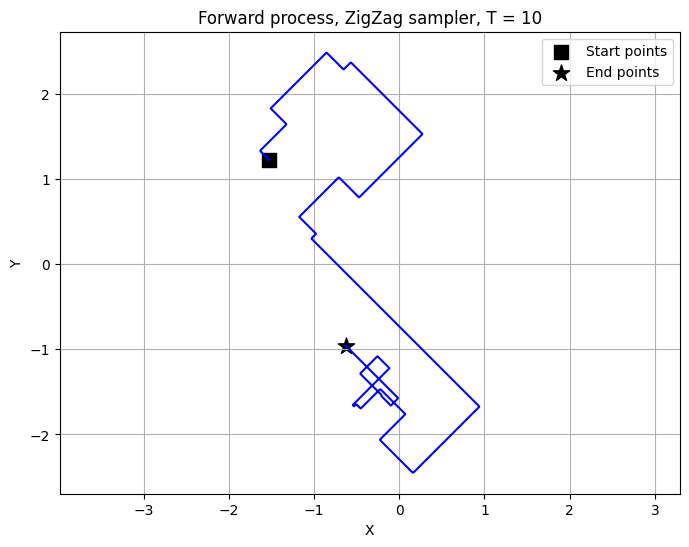

saved to img_forward/ZigZag_10_1.png


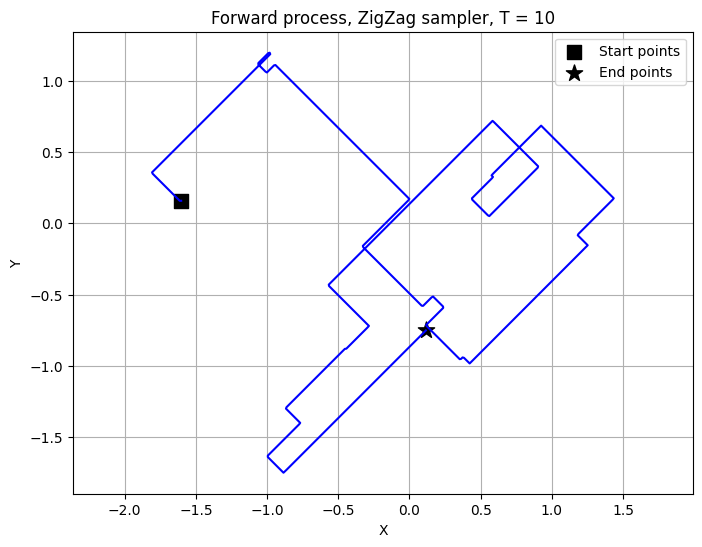

saved to img_forward/ZigZag_10_2.png


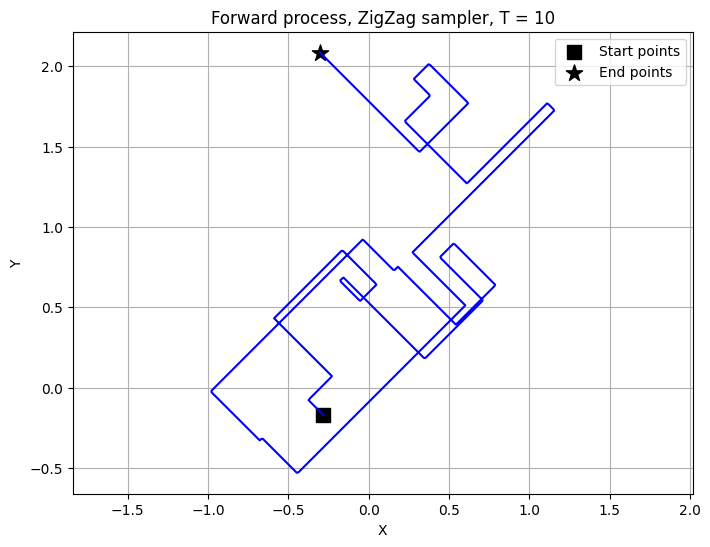

saved to img_forward/ZigZag_10_3.png


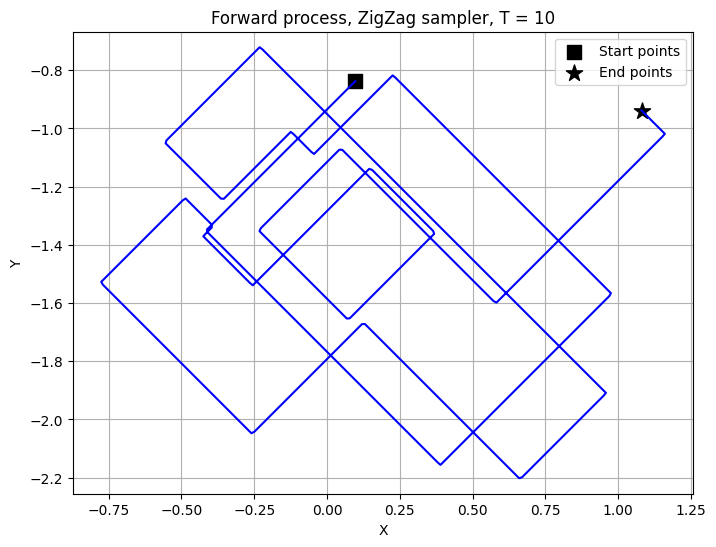

saved to img_forward/ZigZag_10_4.png


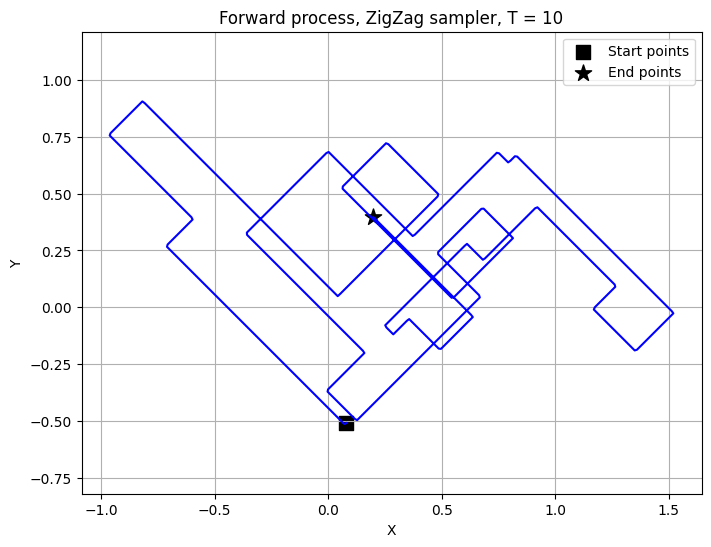

saved to img_forward/ZigZag_10_5.png


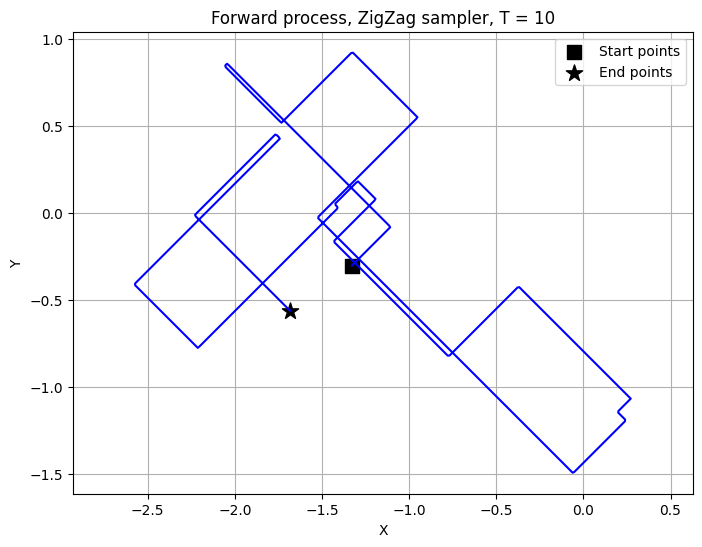

In [32]:
for i in range(6):
    sampler_trajectory(particles=[i], img_idx=i)

animation saved in ./animation/test.mp4


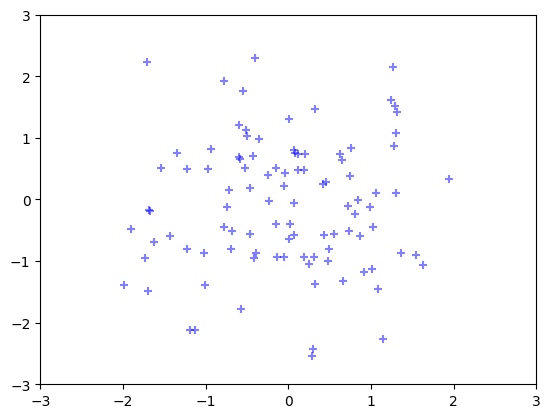

In [13]:
gm = exp.manager.eval.gen_manager
gm.history = history
anim = gm.get_animation(marker='+', pdmp=pdmp_, xlim = (-3, 3), ylim = (-3, 3),)
gm.save_animation(anim, generated_data_name='test')

## time the procedure

**2d data**

In [1]:
import PDMP.manage.Experiments as Exp
import PDMP.manage.Logger as Logger
import timeit

config_file = '2d_data.yml'
store_loc = 'models/tmp'
exp = Exp.Experiment(store_loc, config_file, logger = None)

# time the generation for each sampler

nsamples = 2048
nf = 'NSF' # or 'NSF'
for np, sampler, loss in zip(['diffusion', 'pdmp', 'pdmp', 'pdmp'], ['', 'ZigZag', 'HMC', 'BPS'], ['', 'hyvarinen', 'ml', 'ml']):
    for reverse_steps in [50]: # 50 if 2d, else 10 or 5 if mnist
        exp.p['noising_process'] = np
        exp.p['pdmp']['sampler'] = sampler
        exp.p['pdmp']['add_losses'] = [loss]
        exp.p['eval']['data_to_generate'] = nsamples
        exp.p['eval'][np]['reverse_steps'] = reverse_steps
        exp.p['model']['normalizing_flow']['model_type'] = nf
        exp.prepare()

        print('timing with np={}, sampler={}, reverse_steps={}, nsamples={}, loss={}, nf={}'.format(np, sampler, reverse_steps, nsamples, loss, nf))
        %timeit exp.manager.eval.gen_manager.generate(exp.manager.model, exp.manager.model_vae, nsamples=nsamples, get_sample_history = False, print_progression = False)

using device mps
timing with np=diffusion, sampler=, reverse_steps=50, nsamples=2048, loss=, nf=NSF
394 ms ± 29.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
timing with np=pdmp, sampler=ZigZag, reverse_steps=50, nsamples=2048, loss=hyvarinen, nf=NSF
1.12 s ± 10.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
timing with np=pdmp, sampler=HMC, reverse_steps=50, nsamples=2048, loss=ml, nf=NSF
1.51 s ± 16.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
timing with np=pdmp, sampler=BPS, reverse_steps=50, nsamples=2048, loss=ml, nf=NSF
4.58 s ± 22.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [34]:
import numpy as np 
import matplotlib.pyplot as plt

# Reverse steps and corresponding results
steps = np.array([2, 5, 10, 25, 50, 100, 250])

ddpm_results = np.array([696.28, 192.17, 45.08, 12.34, 11.78, 8.72, 11.71])
bps_results = np.array([165.09, 22.18, 5.48, 1.58, 3.01, 3.66, 2.07])
rhmc_results = np.array([26.48, 3.00, 1.75, 0.60, 0.99, 1.72, 1.03])
zzp_results = np.array([358.25, 89.49, 11.31, 1.20, 0.71, 1.04, 0.42])

# Time per step in milliseconds
ddpm_time_per_step = 3.94
bps_time_per_step = 45.8
rhmc_time_per_step = 15.1
zzp_time_per_step = 11.2

# Compute total computational times
ddpm_times = steps * ddpm_time_per_step
bps_times = steps * bps_time_per_step
rhmc_times = steps * rhmc_time_per_step
zzp_times = steps * zzp_time_per_step

# Create lists with results reclassified by total computational time
ddpm_time_results =     (list(zip(ddpm_times, ddpm_results)))
bps_time_results =      (list(zip(bps_times, bps_results)))
rhmc_time_results =     (list(zip(rhmc_times, rhmc_results)))
zzp_time_results =      (list(zip(zzp_times, zzp_results)))

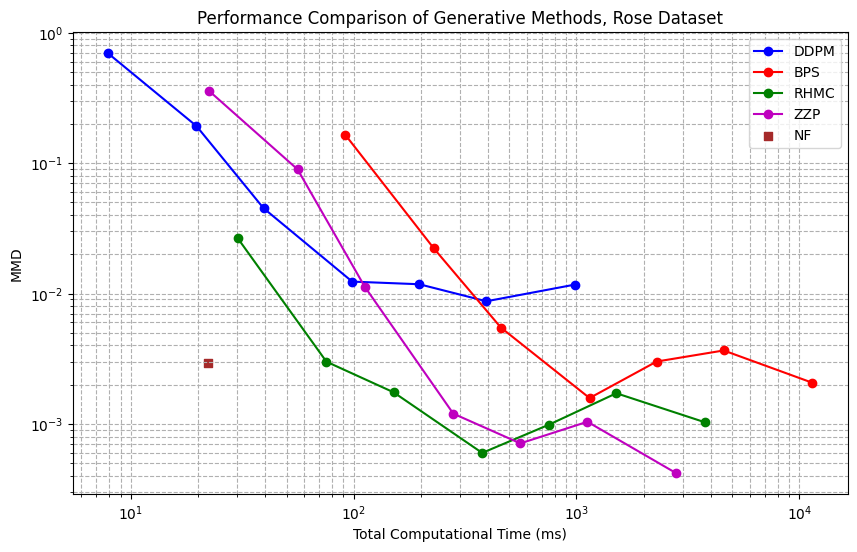

In [54]:
# Extracting times and MMD values for plotting
ddpm_times, ddpm_mmd = zip(*ddpm_time_results)
bps_times, bps_mmd = zip(*bps_time_results)
rhmc_times, rhmc_mmd = zip(*rhmc_time_results)
zzp_times, zzp_mmd = zip(*zzp_time_results)

# Plotting
plt.figure(figsize=(10, 6))

plt.plot(ddpm_times, np.array(ddpm_mmd) * 1e-3, marker='o', linestyle='-', color='b', label='DDPM')
plt.plot(bps_times, np.array(bps_mmd) * 1e-3, marker='o', linestyle='-', color='r', label='BPS')
plt.plot(rhmc_times, np.array(rhmc_mmd) * 1e-3, marker='o', linestyle='-', color='g', label='RHMC')
plt.plot(zzp_times, np.array(zzp_mmd) * 1e-3, marker='o', linestyle='-', color='m', label='ZZP')
plt.scatter([22.1], [0.00291], marker=',', color='brown', label='NF')

# Adding labels and title
plt.xlabel('Total Computational Time (ms)')
plt.ylabel('MMD')
plt.title('Performance Comparison of Generative Methods, Rose Dataset')
plt.xscale('log')  # Using a logarithmic scale for better visualization
plt.yscale('log')  # Using a logarithmic scale for better visualization
plt.legend()
plt.grid(True, which="both", ls="--")

plt.savefig('img_time/mmd_metric', bbox_inches='tight')
# Showing the plot
plt.show()

**image data**

In [2]:
import PDMP.manage.Experiments as Exp
import PDMP.manage.Logger as Logger
import timeit

config_file = 'mnist.yml'
store_loc = 'models/tmp'
exp = Exp.Experiment(store_loc, config_file, logger = None)

# time the generation for each sampler

nsamples = 64
nf = 'MAF' # or 'NSF'
for np, sampler, loss in zip(['diffusion', 'pdmp', 'pdmp', 'pdmp'], ['', 'ZigZag', 'HMC', 'BPS'], ['', 'hyvarinen', 'ml', 'ml']):
    for reverse_steps in [5]: # 50 if 2d, else 10 or 5 if mnist
        exp.p['noising_process'] = np
        exp.p['pdmp']['sampler'] = sampler
        exp.p['pdmp']['add_losses'] = [loss]
        exp.p['eval']['data_to_generate'] = nsamples
        exp.p['eval'][np]['reverse_steps'] = reverse_steps
        exp.p['model']['normalizing_flow']['model_type'] = nf
        exp.prepare()

        print('timing with np={}, sampler={}, reverse_steps={}, nsamples={}, loss={}, nf={}'.format(np, sampler, reverse_steps, nsamples, loss, nf))
        %timeit exp.manager.eval.gen_manager.generate(exp.manager.model, exp.manager.model_vae, nsamples=nsamples, get_sample_history = False, print_progression = False)

using device mps
found eval_files/mnist/original_data
timing with np=diffusion, sampler=, reverse_steps=5, nsamples=64, loss=, nf=MAF
5.55 s ± 133 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
Using Softplus activation on the final layer
found eval_files/mnist/original_data
timing with np=pdmp, sampler=ZigZag, reverse_steps=5, nsamples=64, loss=hyvarinen, nf=MAF
5.73 s ± 128 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
found eval_files/mnist/original_data
timing with np=pdmp, sampler=HMC, reverse_steps=5, nsamples=64, loss=ml, nf=MAF
57.5 s ± 5.12 s per loop (mean ± std. dev. of 7 runs, 1 loop each)
found eval_files/mnist/original_data
timing with np=pdmp, sampler=BPS, reverse_steps=5, nsamples=64, loss=ml, nf=MAF
1min 58s ± 2.12 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Run NF, VAE

In [47]:
import PDMP.manage.Experiments as Exp
import PDMP.manage.Logger as Logger
import timeit

config_file = '2d_data.yml'
store_loc = 'models/tmp'
exp = Exp.Experiment(store_loc, config_file, logger = None)

# time the generation for each sampler

nsamples = 2048
nf = 'NSF' # or 'NSF'
exp.p['noising_process'] = 'nf'
exp.p['model']['vae'] = False
exp.p['data']['dataset'] = 'rose'
exp.p['pdmp']['sampler'] = 'ZigZag'
exp.p['pdmp']['add_losses'] = ['ml']
exp.p['eval']['data_to_generate'] = nsamples
# exp.p['eval'][exp.p['noising_process']]['reverse_steps'] = 10
exp.p['model']['nf']['model_type'] = nf
exp.prepare()
# exp.load(epoch=50)
# print('timing with np={}, sampler={}, reverse_steps={}, nsamples={}, loss={}, nf={}'.format(np, sampler, reverse_steps, nsamples, loss, nf))
# %timeit exp.manager.eval.gen_manager.generate(exp.manager.model, exp.manager.model_vae, nsamples=nsamples, get_sample_history = False, print_progression = False)

using device mps


In [48]:
exp.p['run']['epochs'] = 50
exp.p['run']['eval_freq'] = 10
exp.run()

training model to epoch 50 from epoch 0 ...
epoch_loss 1.1394228076934814
Done training epoch 1/50
epoch_loss 0.8278893947601318
Done training epoch 2/50
epoch_loss 0.7402809596061707
Done training epoch 3/50
epoch_loss 0.705036358833313
Done training epoch 4/50
epoch_loss 0.6976738905906678
Done training epoch 5/50
epoch_loss 0.6763291120529175
Done training epoch 6/50
epoch_loss 0.6661285138130189
Done training epoch 7/50
epoch_loss 0.6410631918907166
Done training epoch 8/50
epoch_loss 0.6312782716751099
Done training epoch 9/50
epoch_loss 0.6491953587532043
Done training epoch 10/50
epoch_loss 0.6048816132545471
Done training epoch 11/50
epoch_loss 0.6064219188690185
Done training epoch 12/50
epoch_loss 0.7202463603019714
Done training epoch 13/50
epoch_loss 0.6179958939552307
Done training epoch 14/50
epoch_loss 0.5839565515518188
Done training epoch 15/50
epoch_loss 0.5717176175117493
Done training epoch 16/50
epoch_loss 0.6652829575538636
Done training epoch 17/50
epoch_loss 0.5

In [49]:
exp.save(curr_epoch=exp.p['run']['epochs'])

('models/tmp/rose/model_8984b3b40c59449d_50.pt',
 'models/tmp/rose/parameters_8984b3b40c59449d.pt',
 'models/tmp/rose/eval_8984b3b40c59449d.pt')

In [51]:
exp.manager.evaluate(data_to_generate = 10000)

evaluating model
wasserstein
wasserstein: 0.011854177099946591
	losses_batch = 0.3809020221233368
	wass = 0.011854177099946591
	mmd = 0.00211757211945951
	precision = 0.9795347308004527
	recall = 0.9847025084100237
	density = 0.0
	coverage = 0.0
	fid = 0.0
	f_1_pr = 0.9821118215655491
	f_1_dc = 0.0
	fig = None


In [52]:
%timeit exp.manager.eval.gen_manager.generate(exp.manager.model, exp.manager.model_vae, nsamples=1024)

26.1 ms ± 354 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


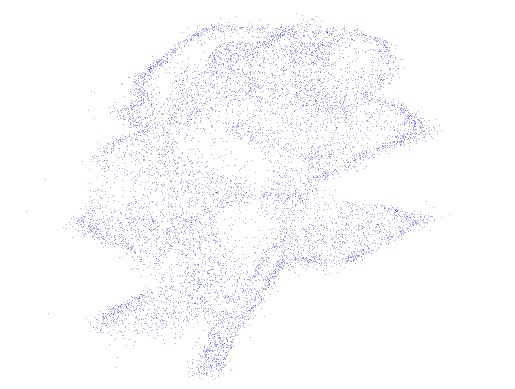

In [55]:
import matplotlib.pyplot as plt
exp.manager.eval.gen_manager.generate(exp.manager.model, exp.manager.model_vae, nsamples=10000)
fig = exp.manager.eval.gen_manager.get_plot(xlim=(-1, 1), ylim=(-1, 1), limit_nb_datapoints=10000, plot_original_data=False)
plt.axis('off')
plt.legend().remove()
fig.savefig('img_new_gen/nf.png', bbox_inches='tight')

In [1]:
import PDMP.manage.Experiments as Exp
import PDMP.manage.Logger as Logger
import timeit
import torch

config_file = '2d_data.yml'
store_loc = 'models/tmp'
exp_vae = Exp.Experiment(store_loc, config_file, logger = None)

# time the generation for each sampler

nsamples = 2048
nf = 'NSF' # or 'NSF'
exp_vae.p['noising_process'] = 'nf'
exp_vae.p['model']['vae'] = True
exp_vae.p['data']['dataset'] = 'rose'
exp_vae.p['pdmp']['sampler'] = 'ZigZag'
exp_vae.p['pdmp']['add_losses'] = ['ml']
exp_vae.p['eval']['data_to_generate'] = nsamples
# exp.p['eval'][exp.p['noising_process']]['reverse_steps'] = 10
exp_vae.p['model']['nf']['model_type'] = nf
exp_vae.prepare()

using device mps


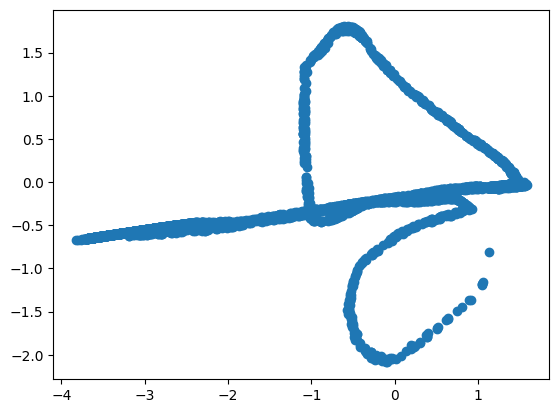

In [9]:
import matplotlib.pyplot as plt
_, (batch, _) = next(enumerate(exp_vae.data))
tmp = exp_vae.manager.model_vae.encoder(batch.to('mps')).mean.detach().clone().cpu().squeeze(1)
# tmp = exp_vae.manager.model_vae.prior().sample((2000,))
# tmp = exp_vae.manager.model_vae.decoder(tmp).sample((1, ))[0].cpu()
plt.scatter(tmp[:, 0], tmp[:, 1])
plt.show()

In [6]:
exp_vae.p['run']['epochs'] = 200
exp_vae.run()

training model to epoch 200 from epoch 100 ...
epoch_loss -1.732265453338623
Done training epoch 101/200
epoch_loss -1.7722561645507813
Done training epoch 102/200
epoch_loss -1.8393604469299316
Done training epoch 103/200
epoch_loss -1.7763465452194214
Done training epoch 104/200
epoch_loss -1.8414671611785889
Done training epoch 105/200
epoch_loss -1.8895660209655762
Done training epoch 106/200
epoch_loss -1.65958336353302
Done training epoch 107/200
epoch_loss -1.8681317472457886
Done training epoch 108/200
epoch_loss -1.893248896598816
Done training epoch 109/200
epoch_loss -1.6437668371200562
Done training epoch 110/200
epoch_loss -1.8443763399124145
Done training epoch 111/200
epoch_loss -1.9077877140045165
Done training epoch 112/200
epoch_loss -1.8768222093582154
Done training epoch 113/200
epoch_loss -1.8657771968841552
Done training epoch 114/200
epoch_loss -1.8880703783035278
Done training epoch 115/200
epoch_loss -1.8758729219436645
Done training epoch 116/200
epoch_loss -1

In [7]:
exp_vae.manager.evaluate()

evaluating model
wasserstein
wasserstein: 0.22250104438057955
	losses_batch = -2.1606078147888184
	wass = 0.22250104438057955
	mmd = 1.1087839603424072
	precision = 0.8013215717902122
	recall = 0.239662079920444
	density = 0.0
	coverage = 0.0
	fid = 0.0
	f_1_pr = 0.36897100980360326
	f_1_dc = 0.0
	fig = None


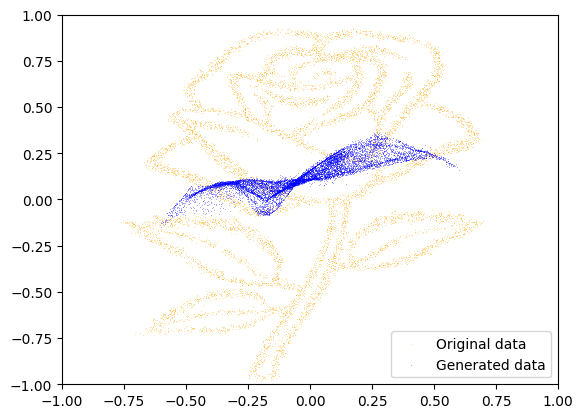

In [8]:
exp_vae.manager.eval.gen_manager.generate(exp_vae.manager.model, exp_vae.manager.model_vae, nsamples=10000)
fig = exp_vae.manager.eval.gen_manager.get_plot(xlim=(-1, 1), ylim=(-1, 1), limit_nb_datapoints=10000, plot_original_data=True)

## Playground

In [62]:
import PDMP.manage.Experiments as Exp
import PDMP.manage.Logger as Logger

In [63]:
exp = Exp.Experiment('models/mnist_zigzag_last_hope_0.2', 'mnist.yml', logger = None)
exp.p['pdmp']['sampler'] = 'ZigZag'
exp.p['pdmp']['time_horizon'] = 5
exp.p['pdmp']['add_losses'] = ['hyvarinen']
exp.p['eval']['data_to_generate'] = 0
exp.prepare()
exp.load(epoch=200)

using device mps
Using Softplus activation on the final layer
found eval_files/mnist/original_data
Using Softplus activation on the final layer
found eval_files/mnist/original_data
loading from model file models/mnist_zigzag_last_hope_0.2/mnist/model_70bd411c6ba1ee73_200.pt
loading from eval file models/mnist_zigzag_last_hope_0.2/mnist/eval_70bd411c6ba1ee73.pt


In [ ]:
nsamples = 5000
batch_size_ = 256
gen_manager = exp.manager.eval.generate_default(exp.manager.model, exp.manager.model_vae, 1)
# get samples
samples = torch.tensor([])
# generate them 
bs = list(np.arange(0, nsamples, batch_size_)) + [nsamples]
for i in range(0, len(bs) - 1):
    bs_samples = bs[i+1] - bs[i]
    print('bs_samples', bs_samples)
    gen_manager.generate(nsamples = bs_samples,model=exp.manager.model, model_vae=exp.manager.model_vae)
    samples = torch.concat((samples, gen_manager.samples.cpu()))
    print('total:', samples.shape[0])

In [67]:
samples = gen_manager.samples

NameError: name 'gen_manager' is not defined

In [80]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
from PDMP.evaluate.fid_score import fid_score, prdc, ImagePathDataset
import torchvision.utils as tvu
import torchvision.transforms as TF
IMAGE_EXTENSIONS = {'bmp', 'jpg', 'jpeg', 'pgm', 'png', 'ppm',
                    'tif', 'tiff', 'webp'}
import pathlib
from PIL import Image


def convert_img_to_uint8(img):
    return np.uint8((img*255).int().numpy())

def save_images(path, images, num_images = 256):
    for i, img in enumerate(images):
        if i >= num_images:
            break
        tvu.save_image(img, os.path.join(path, f"{i}.png"))

def load_images(src_path):
    src_path = pathlib.Path(src_path)
    files = sorted([file for ext in IMAGE_EXTENSIONS
                       for file in src_path.glob('*.{}'.format(ext))])
    dataset = ImagePathDataset(files, transforms=TF.ToTensor())
    return torch.stack(list(dataset))

def denoise_images(src_path, dest_path, func):
    samples = load_images(src_path)[:, :1, ...]
    print('loaded {} images of shape {}'.format(samples.shape[0], samples.shape))
    denoised_images = torch.tensor([])
    bs = list(np.arange(0, nsamples, 256)) + [nsamples]
    for i in range(0, len(bs) - 1):
        bs_samples = bs[i+1] - bs[i]
        print('bs_samples', bs_samples)
        denoised_img = func(samples[bs[i]:bs[i+1]])
        denoised_images = torch.concat((denoised_images, denoised_img))
        # for img in samples:    
            # uint_img = convert_img_to_uint8(img)[0] # removes first and single channel
            # denoised_img = func(uint_img)
            # denoised_img = (torch.Tensor(denoised_img) / 255).unsqueeze(0) # adds channel back
            # denoised_images.append(denoised_img)
    save_images(dest_path, denoised_images, num_images=samples.shape[0])

In [39]:
save_images('img_pdmp/mnist/img/', samples, num_images=samples.shape[0])

**denoise with diffusion**

In [64]:
exp = Exp.Experiment('models/mnist_ddpm', 'mnist.yml', logger = None)
exp.p['noising_process'] = 'diffusion'
exp.p['diffusion']['reverse_steps'] = 100
exp.p['eval']['data_to_generate'] = 0
exp.prepare()
tmp = torch.load('./models/mnist_ddpm/mnist/model_86054eb37cd46958_600.pt', map_location=torch.device('mps'))
# dict_keys(['model_parameters', 'optimizer', 'ema_models', 'epoch', 'steps', 'learning_schedule'])
model = exp.manager.model
model.load_state_dict(tmp['ema_models'][0]) # load ema 0.99
model.eval()
diffusion = exp.manager.noising_process
# exp.load(epoch=600)

using device mps
found eval_files/mnist/original_data


In [65]:
from PDMP.datasets import affine_transform, inverse_affine_transform

def denoise_ddpm(samples):
    xt = samples.to('mps')
    with torch.inference_mode():
        for i in range(10):
            t = torch.ones(samples.shape[0]).to('mps').int() * 1
            eps = model(affine_transform(xt), diffusion._scale_timesteps(t))
            xstart = diffusion._predict_xstart_from_eps(affine_transform(xt), t, eps)
            xt = inverse_affine_transform(xstart)
    return xt.cpu()

In [73]:
samples = load_images('img_pdmp/mnist/img/')[:, :1, ...]

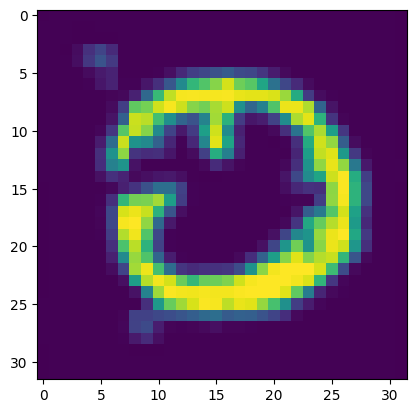

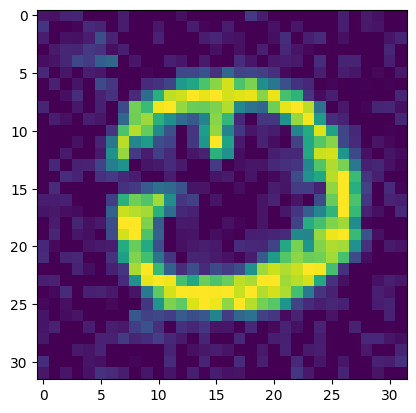

In [75]:
x_init = samples[:16].clone().detach()
xt = denoise_ddpm(samples[:16])
plt.imshow(xt[0].permute(1, 2, 0).cpu())
plt.show()
plt.imshow(x_init[0].permute(1, 2, 0).cpu())
plt.show()

In [82]:
# BEST

# denoise_images('img_pdmp/mnist/img', 'img_pdmp/mnist_dlpm_denoised/img', denoise_ddpm)
fid_score('eval_files/mnist/original_data', 'img_pdmp/mnist_dlpm_denoised/img', batch_size=500, device='mps', dims=2048, num_workers=0)

/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:14<00:00,  1.45s/it]


48.45418555600145

In [ ]:
# save_images('tmp/mnist/', [dataset_files[i][0] for i in range(256)])
# save_images('tmp/mnist_noised/', samples)

In [60]:
fid_score('tmp/mnist/', 'tmp/mnist_noised/', batch_size=256, device='mps', dims=2048, num_workers=0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.39it/s]


196.27528664130205

In [44]:
# BEST

func = lambda x : cv.fastNlMeansDenoising(x, None, h=25, templateWindowSize=5, searchWindowSize=32)
denoise_images('img_pdmp/mnist/img', 'img_pdmp/mnist_denoised/img', func)
fid_score('eval_files/mnist/original_data', 'img_pdmp/mnist_denoised/img', batch_size=256, device='mps', dims=2048, num_workers=0)

/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/anaconda3/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:11<00:00,  1.72it/s]


31.10771165792042

In [61]:
func = lambda x : cv.fastNlMeansDenoising(x, None, h=20, templateWindowSize=5, searchWindowSize=32)
denoise_images('tmp/mnist_noised/', 'tmp/mnist_denoised/', func)
fid_score('tmp/mnist/', 'tmp/mnist_denoised/', batch_size=256, device='mps', dims=2048, num_workers=0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.06s/it]


70.53377623886234

In [62]:
func = lambda x : cv.fastNlMeansDenoising(x, None, h=20, templateWindowSize=3, searchWindowSize=32)
denoise_images('tmp/mnist_noised/', 'tmp/mnist_denoised/', func)
fid_score('tmp/mnist/', 'tmp/mnist_denoised/', batch_size=256, device='mps', dims=2048, num_workers=0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.40it/s]


95.97658772090352

In [63]:
func = lambda x : cv.fastNlMeansDenoising(x, None, h=20, templateWindowSize=7, searchWindowSize=32)
denoise_images('tmp/mnist_noised/', 'tmp/mnist_denoised/', func)
fid_score('tmp/mnist/', 'tmp/mnist_denoised/', batch_size=256, device='mps', dims=2048, num_workers=0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.37it/s]


81.98850097230886

In [64]:
func = lambda x : cv.fastNlMeansDenoising(x, None, h=15, templateWindowSize=3, searchWindowSize=32)
denoise_images('tmp/mnist_noised/', 'tmp/mnist_denoised/', func)
fid_score('tmp/mnist/', 'tmp/mnist_denoised/', batch_size=256, device='mps', dims=2048, num_workers=0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.31it/s]


121.84510452203546

In [65]:
func = lambda x : cv.fastNlMeansDenoising(x, None, h=30, templateWindowSize=3, searchWindowSize=32)
denoise_images('tmp/mnist_noised/', 'tmp/mnist_denoised/', func)
fid_score('tmp/mnist/', 'tmp/mnist_denoised/', batch_size=256, device='mps', dims=2048, num_workers=0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.07it/s]


79.09094791220889

In [66]:
func = lambda x : cv.fastNlMeansDenoising(x, None, h=30, templateWindowSize=5, searchWindowSize=32)
denoise_images('tmp/mnist_noised/', 'tmp/mnist_denoised/', func)
fid_score('tmp/mnist/', 'tmp/mnist_denoised/', batch_size=256, device='mps', dims=2048, num_workers=0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.28it/s]


57.96780852483411

In [67]:
func = lambda x : cv.fastNlMeansDenoising(x, None, h=30, templateWindowSize=7, searchWindowSize=32)
denoise_images('tmp/mnist_noised/', 'tmp/mnist_denoised/', func)
fid_score('tmp/mnist/', 'tmp/mnist_denoised/', batch_size=256, device='mps', dims=2048, num_workers=0)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.08s/it]


59.61424211704701

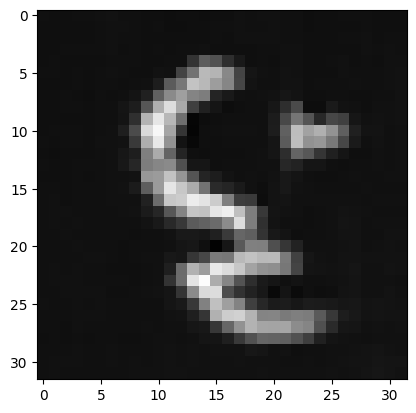

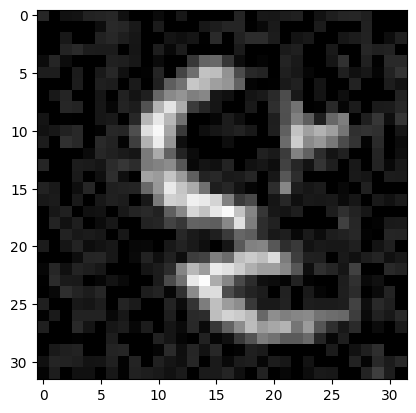

tensor([[[0.0627, 0.0627, 0.0627],
         [0.0588, 0.0588, 0.0588],
         [0.0588, 0.0588, 0.0588],
         ...,
         [0.0588, 0.0588, 0.0588],
         [0.0588, 0.0588, 0.0588],
         [0.0588, 0.0588, 0.0588]],

        [[0.0588, 0.0588, 0.0588],
         [0.0588, 0.0588, 0.0588],
         [0.0588, 0.0588, 0.0588],
         ...,
         [0.0588, 0.0588, 0.0588],
         [0.0588, 0.0588, 0.0588],
         [0.0588, 0.0588, 0.0588]],

        [[0.0588, 0.0588, 0.0588],
         [0.0588, 0.0588, 0.0588],
         [0.0588, 0.0588, 0.0588],
         ...,
         [0.0588, 0.0588, 0.0588],
         [0.0627, 0.0627, 0.0627],
         [0.0627, 0.0627, 0.0627]],

        ...,

        [[0.0627, 0.0627, 0.0627],
         [0.0627, 0.0627, 0.0627],
         [0.0627, 0.0627, 0.0627],
         ...,
         [0.0784, 0.0784, 0.0784],
         [0.0706, 0.0706, 0.0706],
         [0.0667, 0.0667, 0.0667]],

        [[0.0627, 0.0627, 0.0627],
         [0.0667, 0.0667, 0.0667],
         [0.

In [47]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import torch
tmp = samples[3][0]
tmp_noised = np.uint8((tmp*255).int().numpy())
tmp_denoised = cv.fastNlMeansDenoising(tmp_noised, None, h=25, templateWindowSize=5, searchWindowSize=32)
#plt.imshow(tmp)
tmp_denoised = (torch.Tensor(tmp_denoised) / 255).unsqueeze(-1).repeat(1, 1, 3)
plt.imshow(tmp_denoised)
plt.show()
tmp_denoised
# plt.imshow(inverse_affine_transform(dataset_files[0][0][0]).unsqueeze(-1).repeat(1, 1, 3))
# plt.show()
plt.imshow(tmp.unsqueeze(-1).repeat(1, 1, 3))
plt.show()
quantiles = torch.quantile(tmp_denoised, torch.tensor([0.25, 0.95]))
# tmp_denoised[tmp_denoised < quantiles[0]] = 0
# tmp_denoised[tmp_denoised > quantiles[1]] = 1
tmp_denoised

In [27]:
exp.run()

  0%|                                                                                                                                                   | 0/50 [00:00<?, ?it/s]

training for 25 epochs...

 50%|█████████████████████████████████████████████████████████████████████                                                                     | 25/50 [00:15<00:15,  1.64it/s]

done
('models/tmp/sas_grid/model_46251f0ace0b28d3_25.pt', 'models/tmp/sas_grid/parameters_46251f0ace0b28d3.pt', 'models/tmp/sas_grid/eval_46251f0ace0b28d3.pt')
starting evaluation of the model:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:06<00:00, 33.28it/s]


wasserstein
wasserstein: 0.11607203364030101
	losses_batch = 2.6688969135284424
	wass = 0.11607203364030101
	precision = 0.5697083329021716
	recall = 0.9011109764600158
	density = 0.0
	coverage = 0.0
	fid = 0.0
	f_1_pr = 0.6980740990971946
	f_1_dc = 0.0
	fig = None
starting evaluation of the EMAs:
epochs left: 25
training for 25 epochs...

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:38<00:00,  1.64it/s]

done
('models/tmp/sas_grid/model_46251f0ace0b28d3_50.pt', 'models/tmp/sas_grid/parameters_46251f0ace0b28d3.pt', 'models/tmp/sas_grid/eval_46251f0ace0b28d3.pt')
starting evaluation of the model:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:06<00:00, 33.16it/s]


wasserstein
wasserstein: 0.09727739652042552


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:45<00:00,  1.09it/s]

	losses_batch = 2.5476770401000977
	wass = 0.09727739652042552
	precision = 0.6465500029237452
	recall = 0.9213432795263303
	density = 0.0
	coverage = 0.0
	fid = 0.0
	f_1_pr = 0.7598661295884337
	f_1_dc = 0.0
	fig = None
starting evaluation of the EMAs:
epochs left: 0


In [28]:
gen_model = exp.get_generator()

In [29]:
gen_model.generate(1000, get_sample_history=True)

  0%|                                                                                                                                                  | 0/200 [00:00<?, ?it/s]

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:05<00:00, 33.80it/s]


'./animation/sas_grid_HMC.mp4'

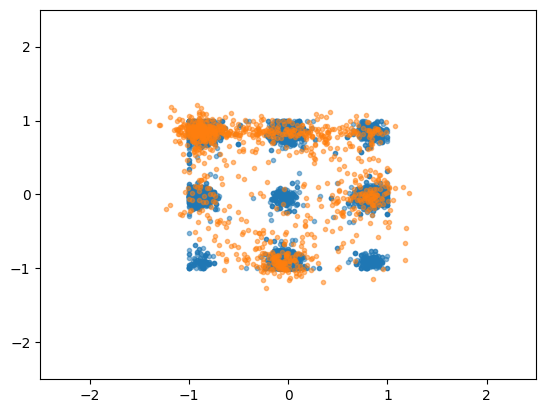

In [31]:
gen_model.animation(plot_original_data=True, limit_nb_orig_data=10000, generated_data_name='_'.join((exp.p['data']['dataset'], exp.p['pdmp']['sampler_name'])))

In [ ]:
# Import required packages
import torch
import numpy as np
import normflows as nf
import zuko

from matplotlib import pyplot as plt

from tqdm import tqdm

In [ ]:
# Neural spline flow (NSF) with 3 sample features and 5 context features
model = zuko.flows.NSF(2, 1, transforms=3, hidden_features=[128] * 3)

In [ ]:
# Set up model

# Define 2D Gaussian base distribution
base = nf.distributions.base.DiagGaussian(2)

# Define list of flows
num_layers = 32
flows = []
for i in range(num_layers):
    # Neural network with two hidden layers having 64 units each
    # Last layer is initialized by zeros making training more stable
    param_map = nf.nets.MLP([1+1, 64, 64, 2], init_zeros=True) # 3 additional condition dimensions
    # Add flow layer
    flows.append(nf.flows.AffineCouplingBlock(param_map))
    # Swap dimensions
    flows.append(nf.flows.Permute(2, mode='swap'))
    
# Construct flow model
model = nf.ConditionalNormalizingFlow(base, flows)

In [ ]:
# Move model on GPU if available
enable_cuda = True
device = 'mps' #torch.device('cuda' if torch.cuda.is_available() and enable_cuda else 'cpu')
model = model.to(device)

In [ ]:
# Define target distribution
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

num_samples = 10000
target_0 = nf.distributions.TwoMoons().sample(num_samples)
context_0 = torch.zeros(num_samples).unsqueeze(-1)
target_1 = nf.distributions.CircularGaussianMixture().sample(num_samples)
context_1 = torch.ones(num_samples).unsqueeze(-1)
target = torch.cat((target_0, target_1), dim=0)
context = torch.cat((context_0, context_1), dim=0)
# shuffle entries of target
idx = torch.randperm(target.shape[0])
target = target[idx]
context = context[idx]

dataset = TensorDataset(target, context) #attached a class to the data, will be useful on other datasets
data = DataLoader(dataset, 
                batch_size=target.shape[0] // 8, 
                shuffle=True, 
                num_workers=0)

In [ ]:
loss_hist = np.array([])
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5) # 5e-4

In [ ]:
# Train model
max_iter = 1000

it = 0
for it in tqdm(range(0, max_iter, len(data))):
    for _, (x, context) in (enumerate(data)):
        optimizer.zero_grad()
        
        # Get training samples
        #x = target.sample(num_samples).to(device)
        x, context = x.to(device), context.to(device)
        
        # Compute loss
        #loss = model.forward_kld(x, context=context)
        loss = -model(context).log_prob(x)
        loss = loss.mean()

        # Do backprop and optimizer step
        if ~(torch.isnan(loss) | torch.isinf(loss)):
            loss.backward()
            optimizer.step()
        
        # Log loss
        loss_hist = np.append(loss_hist, loss.to('cpu').data.numpy())
    if (it% (50*len(data))) == 0:
        print('Loss: ', loss)
    #print('Loss: ', loss)

# Plot loss
plt.figure(figsize=(10, 10))
plt.plot(loss_hist, label='loss')
plt.legend()
plt.show()

In [ ]:
# Plot target distribution
f, ax = plt.subplots(1, 2, sharey=True, figsize=(15, 7))
# Plot target distribution
grid_size = 200
xx, yy = torch.meshgrid(torch.linspace(-3, 3, grid_size), torch.linspace(-3, 3, grid_size))
zz = torch.cat([xx.unsqueeze(2), yy.unsqueeze(2)], 2).view(-1, 2)
zz = zz.to(device)

#log_prob = target.log_prob(zz).to('cpu').view(*xx.shape)
#prob = torch.exp(log_prob)
#prob[torch.isnan(prob)] = 0
# Plot learned distribution
model.eval()
log_prob = model(0*torch.ones(zz.shape[0], 1).to(device)).log_prob(zz).to('cpu').view(*xx.shape) #model.log_prob(zz, 0*torch.ones(zz.shape[0], 1)).to('cpu').view(*xx.shape)
model.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

ax[0].pcolormesh(xx, yy, prob.data.numpy(), cmap='coolwarm')

ax[0].set_aspect('equal', 'box')
ax[0].set_axis_off()
ax[0].set_title('TwoMoons, class 0', fontsize=24)

# Plot learned distribution
model.eval()
log_prob = model(1*torch.ones(zz.shape[0], 1).to(device)).log_prob(zz).to('cpu').view(*xx.shape)#model.log_prob(zz, 1*torch.ones(zz.shape[0], 1)).to('cpu').view(*xx.shape)
model.train()
prob = torch.exp(log_prob)
prob[torch.isnan(prob)] = 0

ax[1].pcolormesh(xx, yy, prob.data.numpy(), cmap='coolwarm')

ax[1].set_aspect('equal', 'box')
ax[1].set_axis_off()
ax[1].set_title('Gaussian Circle, class 1', fontsize=24)

plt.subplots_adjust(wspace=0.1)

plt.show()

In [ ]:
model(torch.zeros(10, 1).to(device)).sample()

## Setup

* Forward, backward, loss in PDMP class
* Other classes automatically take care of training, evaluation, saving, loading etc

Prepare all our objects:

In [ ]:
from IPython.display import HTML
from IPython.display import display
import os
import yaml
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons

import numpy as np
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import initial_code.pdmp as PDMP
import Data as Data
from Model import LevyDiffusionModel
import torch.optim as optim
import torch.nn as nn
import Generate as Gen
import matplotlib.pyplot as plt
import evaluate.Eval as Eval
import Manager 
import zuko

%matplotlib inline

p_model_2d = {
    'act' : 'silu',
    'skip_connection' : True,
    'group_norm' : True,
    'dropout_rate' : .0,
    'nblocks' : 32,
    'nunits' : 64,
    'use_a_t' : False,
    'no_a': True,
    'a_pos_emb': False, # cannot have no_a and a_pos_emb
    'a_emb_size': 32,
    'time_emb_type' : 'learnable',#'learnable',# 'one_dimensional_input',
    'time_emb_size' : 8, 
    'compute_gamma': False,
}

p_data_2d = {
    'nfeatures' : 2, # if data_type is 2d, will just project on first dimension
    'nsamples' : 4*8*1024,
    #'bs': ..., may need to add
    'dataset' : 'gmm_2',
    'std' : 0.1, # 0.5, 0.05,
    'n_mixture' : 2, # must be square. set to None if not a grid mixture
    'normalize' : True,
    #'weights': np.array([1/2]*2),
    'weights': None,#[.01, .1, .3, 
               # .2, .02, .15,
               # .02, .15, .05],# None, #np.array([.05, .95]),
    'theta': 1.,
    'alpha': 2.,
    #'isotropic': True
}

device = 'mps'
# device = 'cpu'

# original data, get dataloader
gmm_2 = Data.Generator(**p_data_2d)#('gmm_2', n_samples = 32000, theta=1, std = 0.1)
GMM2 = gmm_2.generate()
GMM2 = GMM2.unsqueeze(1) # add channel
dataset = TensorDataset(GMM2, torch.tensor([0.]).repeat(GMM2.shape[0])) #attached a class to the data, will be useful on other datasets
data = DataLoader(dataset, 
                batch_size=p_data_2d['nsamples'] // 8, 
                shuffle=True, 
                num_workers=0)

# model
#model = LevyDiffusionModel({'data': {'nfeatures': p_data_2d['nfeatures']}, 'model':p_model_2d, 'device': 'cpu'}).to(device)
# Neural spline flow (NSF) with 3 sample features and 5 context features
model = zuko.flows.NSF(2, 3, transforms=3, hidden_features=[128] * 3).to(device)

# optimizer
optimizer = optim.AdamW(model.parameters(), 
                        lr=5e-4, 
                        betas=(0.9, 0.99)) # beta_2 0.95 instead of 0.999

# PDMP class
pdmp = PDMP.PDMP(time_horizon = 10, reverse_steps = 250, device=device, sampler_name='ZigZag', refresh_rate = 0.)

# Manager for data generation
gen_model = Gen.GenerationManager(model, pdmp, data)

eval_class = Eval.Eval(model, pdmp, data, is_image=False)
manager = Manager.Manager(model, 
                 data,
                 pdmp, 
                 optimizer,
                 learning_schedule = None,
                 eval = eval_class,
                 ema_rates = None,)


In [22]:
from IPython.display import HTML
from IPython.display import display
import os
import yaml
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons

import numpy as np
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import initial_code.pdmp as PDMP
import Data as Data
from Model import LevyDiffusionModel
import torch.optim as optim
import torch.nn as nn
import Generate as Gen
import matplotlib.pyplot as plt
import evaluate.Eval as Eval
import Manager 
import zuko

%matplotlib inline

p_model_2d = {
    'act' : 'silu',
    'skip_connection' : True,
    'group_norm' : True,
    'dropout_rate' : .0,
    'nblocks' : 32,
    'nunits' : 64,
    'use_a_t' : False,
    'no_a': True,
    'a_pos_emb': False, # cannot have no_a and a_pos_emb
    'a_emb_size': 32,
    'time_emb_type' : 'learnable',#'learnable',# 'one_dimensional_input',
    'time_emb_size' : 8, 
    'compute_gamma': False,
}

p_data_2d = {
    'nfeatures' : 2, # if data_type is 2d, will just project on first dimension
    'nsamples' : 4*8*1024,
    #'bs': ..., may need to add
    'dataset' : 'gmm_2',
    'std' : 0.1, # 0.5, 0.05,
    'n_mixture' : 2, # must be square. set to None if not a grid mixture
    'normalize' : True,
    #'weights': np.array([1/2]*2),
    'weights': None,#[.01, .1, .3, 
               # .2, .02, .15,
               # .02, .15, .05],# None, #np.array([.05, .95]),
    'theta': 1.,
    'alpha': 2.,
    #'isotropic': True
}

device = 'mps'
# device = 'cpu'

# original data, get dataloader
gmm_2 = Data.Generator(**p_data_2d)#('gmm_2', n_samples = 32000, theta=1, std = 0.1)
GMM2 = gmm_2.generate()
GMM2 = GMM2.unsqueeze(1) # add channel
dataset = TensorDataset(GMM2, torch.tensor([0.]).repeat(GMM2.shape[0])) #attached a class to the data, will be useful on other datasets
data = DataLoader(dataset, 
                batch_size=p_data_2d['nsamples'] // 8, 
                shuffle=True, 
                num_workers=0)

# model
model = LevyDiffusionModel({'data': {'nfeatures': p_data_2d['nfeatures']}, 'model':p_model_2d, 'device': 'cpu'}).to(device)
# Neural spline flow (NSF) with 3 sample features and 5 context features
# model = zuko.flows.NSF(2, 3, transforms=4, hidden_features=[128] * 3).to(device)

# optimizer
optimizer = optim.AdamW(model.parameters(), 
                        lr=5e-4, 
                        betas=(0.9, 0.99)) # beta_2 0.95 instead of 0.999

# PDMP class
pdmp = PDMP.PDMP(time_horizon = 7, reverse_steps = 150, device=device, sampler_name='ZigZag', refresh_rate = 0., backward_scheme='splitting')
# pdmp = PDMP.PDMP(time_horizon = 5, reverse_steps = 25, device=device, sampler_name='HMC', refresh_rate = 1., backward_scheme='splitting')

# Manager for data generation
gen_model = Gen.GenerationManager(model, pdmp, data)

eval_class = Eval.Eval(model, pdmp, data, is_image=False)
manager = Manager.Manager(model, 
                 data,
                 pdmp, 
                 optimizer,
                 learning_schedule = None,
                 eval = eval_class,
                 ema_rates = None,)

0


## Look at the noised data

In [23]:
import PDMP.manage.Experiments as Exp
import PDMP.manage.Logger as Logger
import os
import yaml

from util_pdmp import *

# open and get parameters from file
with open(os.path.join(CONFIG_PATH, '2d_data' + '.yml'), "r") as f:
    p = yaml.safe_load(f)


# create experiment object. Specify directory to save and load checkpoints,
# experiment parameters, and potential logger object
exp = Exp.Experiment(os.path.join('models', 'tmp'), 
                        p, 
                        logger = None) # Logger.NeptuneLogger()

exp.p['pdmp']['time_horizon'] = 5
exp.prepare()

# print parameters
#exp.print_parameters()

using device mps
removing files in directory eval_files/gmm_2/generated_data/3c51745c352e71e2_f91a989f
removing files in directory eval_files/gmm_2/original_data/3c51745c352e71e2_f91a989f


  0%|                                                                                                                                    | 0/10 [00:00<?, ?it/s]

training for 10 epochs...tensor([2.4108, 0.2251, 3.8779,  ..., 0.9396, 0.3507, 4.3461])
tensor([0.0589, 1.3362, 1.0823,  ..., 5.7648, 8.4766, 0.3278])
tensor([9.1355, 0.0208, 2.3567,  ..., 0.1810, 8.7623, 0.1273])
tensor([0.2804, 0.2649, 7.3082,  ..., 0.8543, 7.5533, 0.1458])


 10%|████████████▍                                                                                                               | 1/10 [00:00<00:07,  1.17it/s]

tensor([2.0996e-02, 7.0870e+00, 5.0773e-02,  ..., 1.9446e-03, 6.6872e+00,
        1.2939e+00])
tensor([2.7924, 0.5230, 7.1628,  ..., 1.6038, 0.3867, 1.2061])
tensor([6.0983, 3.8221, 5.3302,  ..., 2.1607, 7.3605, 0.2556])
tensor([6.1219, 1.9752, 6.0515,  ..., 1.2165, 9.6174, 6.7661])


 20%|████████████████████████▊                                                                                                   | 2/10 [00:01<00:06,  1.19it/s]

tensor([3.8456, 0.1135, 6.9415,  ..., 1.9151, 0.0877, 4.3717])
tensor([0.4633, 3.3001, 3.1471,  ..., 4.0733, 0.6235, 0.1379])
tensor([4.6329, 4.2904, 0.8542,  ..., 2.4252, 1.1073, 0.9700])
tensor([7.0488, 0.1043, 0.6843,  ..., 9.2601, 3.4490, 1.5716])


 30%|█████████████████████████████████████▏                                                                                      | 3/10 [00:02<00:05,  1.19it/s]

tensor([1.0900, 1.9346, 0.0153,  ..., 3.1889, 2.1895, 2.1132])
tensor([0.0922, 2.3240, 4.3063,  ..., 0.0828, 0.1369, 5.7492])
tensor([1.4821e+00, 7.9309e+00, 1.2465e+00,  ..., 3.7739e+00, 3.6243e-03,
        5.9095e+00])


 40%|█████████████████████████████████████████████████▌                                                                          | 4/10 [00:03<00:05,  1.19it/s]

tensor([6.5067, 2.5864, 2.8491,  ..., 1.9171, 3.8078, 2.3584])
tensor([0.2821, 0.0379, 2.1415,  ..., 5.5768, 7.5207, 2.1668])
tensor([4.6739e+00, 5.7487e+00, 8.8636e+00,  ..., 7.0583e-03, 5.3405e+00,
        9.5544e+00])
tensor([0.7071, 1.4379, 5.0694,  ..., 5.1024, 2.3379, 9.7691])


 50%|██████████████████████████████████████████████████████████████                                                              | 5/10 [00:04<00:04,  1.19it/s]

tensor([0.0201, 0.1863, 3.1502,  ..., 3.7039, 0.9084, 7.4237])
tensor([5.5607, 0.2233, 1.2433,  ..., 0.1370, 7.1930, 3.0444])
tensor([0.0152, 8.4734, 4.8406,  ..., 5.5420, 3.6151, 2.5316])
tensor([2.6027, 7.3035, 2.1856,  ..., 8.1912, 2.1093, 3.6239])


 60%|██████████████████████████████████████████████████████████████████████████▍                                                 | 6/10 [00:05<00:03,  1.18it/s]

tensor([2.5449, 0.1009, 3.3194,  ..., 1.1038, 7.4275, 1.3573])
tensor([0.0160, 0.8390, 9.1641,  ..., 9.0246, 8.1643, 3.8889])
tensor([4.2970, 4.8699, 1.3942,  ..., 9.1155, 4.6394, 8.8887])
tensor([0.0951, 0.0143, 0.0554,  ..., 7.1815, 2.1994, 1.2689])


 70%|██████████████████████████████████████████████████████████████████████████████████████▊                                     | 7/10 [00:05<00:02,  1.19it/s]

tensor([4.9489e+00, 1.2126e+00, 4.1972e-03,  ..., 7.5985e+00, 7.0436e-01,
        7.3728e-01])
tensor([6.1059, 1.4567, 0.1249,  ..., 9.7218, 2.9362, 0.4549])
tensor([2.7627, 1.6230, 7.4229,  ..., 7.1305, 5.2884, 5.1693])
tensor([1.6388e+00, 2.5061e+00, 9.6813e+00,  ..., 8.0397e-03, 2.4427e-01,
        2.6741e+00])


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                        | 8/10 [00:06<00:01,  1.23it/s]

tensor([0.6309, 7.8358, 1.2459,  ..., 8.4937, 2.3646, 1.1225])
tensor([3.2496, 2.2180, 3.0965,  ..., 6.7313, 0.9547, 0.6837])
tensor([6.9375, 5.3621, 8.5624,  ..., 1.3268, 0.0520, 2.1382])
tensor([5.0150, 0.0224, 0.1554,  ..., 4.4737, 2.6187, 8.3166])
tensor([8.4590, 3.8077, 5.8272,  ..., 0.2874, 0.7987, 1.1786])


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 9/10 [00:07<00:00,  1.22it/s]

tensor([9.3946, 4.2067, 0.6408,  ..., 0.0251, 0.9886, 6.1636])
tensor([0.3005, 7.2476, 4.4278,  ..., 2.8438, 2.4000, 3.0629])
tensor([5.3288, 4.2736, 2.2064,  ..., 6.5356, 6.0741, 7.7084])
tensor([2.7037, 5.2552, 4.9089,  ..., 5.7039, 0.2095, 3.7071])


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:08<00:00,  1.22it/s]

done
starting evaluation of the model:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 59.37it/s]


wasserstein
wasserstein: 0.23571394338647556
	losses_batch = 31.447307586669922
	wass = 0.23571394338647556
	precision = 0.06051678598862838
	recall = 0.353536835986936
	density = 0.0
	coverage = 0.0
	fid = 0.0
	f_1_pr = 0.10334368259085464
	f_1_dc = 0.0
	fig = None
saving at epoch number 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:17<00:00,  1.71s/it]

epochs left: 0


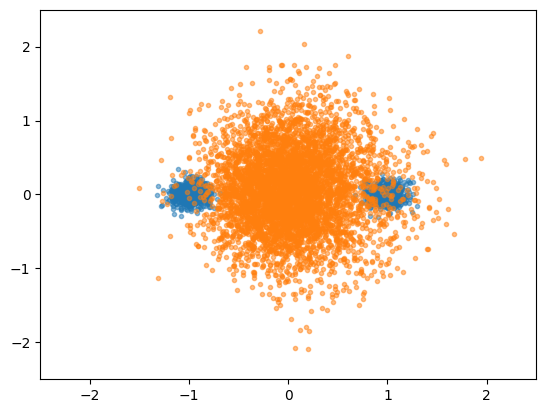

In [11]:
# run the experiment
exp.run( 
    progress=p['run']['progress'],
    verbose = True,
    no_ema_eval=True, # to speed up testing
    )

# in any case, save last models.
#print(exp.save())

# close everything
exp.terminate()

In [ ]:
# can use this to load a model, optimizer, learning schedule, and eval metrics

MODEL_PATH = 'models/model.pt'
EVAL_PATH = 'models/eval_model.pt'

manager.load(MODEL_PATH)
manager.load_eval_metrics(EVAL_PATH)

In [61]:
import torch
# clone data, since it will be modified by forward process
#data_clone = GMM2.clone()
print(exp.manager.noising_process.T)
def pdmp_original(T):
    data_clone= exp.manager.eval.gen_manager.load_original_data(10000).to('cpu')

    # orint its shape
    print(data_clone.shape)
    # # get a unit time horizon
    time_horizons = torch.ones(data_clone.shape).to('cpu')

    for i in range(T):
        t = time_horizons.clone()
        pdmp.forward(data_clone, t)
    return data_clone


def pdmp_refactor(T):
    data_clone= exp.manager.eval.gen_manager.load_original_data(10000).to('mps')

    # orint its shape
    print(data_clone.shape)
    # # get a unit time horizon
    time_horizons = torch.ones(data_clone.shape).to('mps')

    for i in range(T):
        t = time_horizons.clone()
        exp.manager.noising_process.forward(data_clone, t)
    return data_clone

#data_clone=pdmp_original(7)
data_clone=pdmp_refactor(7)
#* pdmp.T
# forward process for pmdp.T time units
#pdmp.forward(data_clone, time_horizons)

5
torch.Size([10000, 1, 2])


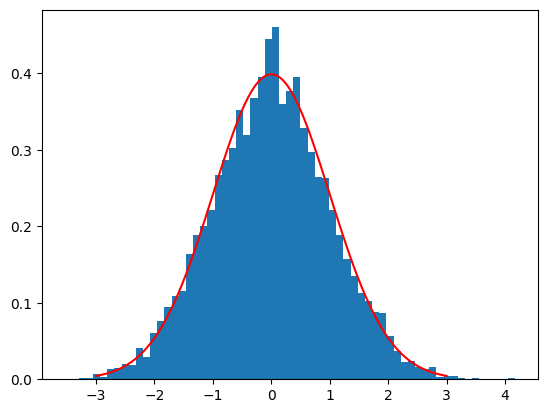

In [62]:
# look at histogram of one component at the last timestep
import numpy as np
import matplotlib.pyplot as plt

pos = data_clone.squeeze(1).cpu() # remove channel dimension
import scipy.stats as stats
X = np.linspace(-3, 3, 100)
Y = stats.norm.pdf(X, 0, 1)
plt.plot(X, Y, color='red')
plt.hist(pos[:, 0], bins='auto', density=True)
plt.show()

* Still need some work to get to the Monte-Carlo estimation for every possible values of speed.

In [ ]:
# clone data, since it will be modified by forward process
M = 1
L = []
lims = 3
T = np.linspace(0, 5, 100)
for t in T:
    # Define the number of bins in each dimension
    num_bins = 100  # You can adjust this value as needed
    tmp = []
    for m in range(M):
        data_clone = GMM2.clone()
        pdmp.forward(data_clone, torch.ones(data_clone.shape)*t)
        data_clone = data_clone.clamp(-lims, lims).squeeze(1).numpy()
        # Compute the 2D histogram
        hist, x_edges, y_edges = np.histogram2d(data_clone[:,0], data_clone[:,1], bins=num_bins, range=[[-lims, lims], [-lims, lims]], density=True)
        tmp.append(hist)
        # 'hist' contains the 2D histogram values
        # 'x_edges' and 'y_edges' are the bin edges in the x and y dimensions, respectively
    tmp = np.array(tmp)
    tmp = tmp.mean(axis = 0)
    L.append(tmp)
L = np.array(L)

In [ ]:
plt.imshow(L[5], origin='lower', aspect='auto')#extent=[x_edges[0], x_edges[-1], y_edges[0], y_edges[-1]])
plt.colorbar()  # Add a color bar to indicate the scale
plt.xlabel('X')  # Label for the x-axis
plt.ylabel('Y')  # Label for the y-axis
plt.title('p_t(x) Heatmap')  # Title of the heatmap
plt.show()  # Display the heatmap

## Train the model

In [3]:
from IPython.display import HTML
from IPython.display import display
import os
import yaml
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, RadioButtons

import numpy as np
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import initial_code.pdmp as PDMP
import PDMP.compute.pdmp as pdm
import Data as Data
from Model import LevyDiffusionModel
import torch.optim as optim
import torch.nn as nn
import Generate as Gen
import matplotlib.pyplot as plt
import evaluate.Eval as Eval
import Manager 
import zuko

%matplotlib inline

p_model_2d = {
    'act' : 'silu',
    'skip_connection' : True,
    'group_norm' : True,
    'dropout_rate' : .0,
    'nblocks' : 32,
    'nunits' : 64,
    'use_a_t' : False,
    'no_a': True,
    'a_pos_emb': False, # cannot have no_a and a_pos_emb
    'a_emb_size': 32,
    'time_emb_type' : 'learnable',#'learnable',# 'one_dimensional_input',
    'time_emb_size' : 8, 
    'compute_gamma': False,
}

p_data_2d = {
    'nfeatures' : 2, # if data_type is 2d, will just project on first dimension
    'nsamples' : 4*8*1024,
    #'bs': ..., may need to add
    'dataset' : 'gmm_2',
    'std' : 0.1, # 0.5, 0.05,
    'n_mixture' : 2, # must be square. set to None if not a grid mixture
    'normalize' : True,
    #'weights': np.array([1/2]*2),
    'weights': None,#[.01, .1, .3, 
               # .2, .02, .15,
               # .02, .15, .05],# None, #np.array([.05, .95]),
    'theta': 1.,
    'alpha': 2.,
    #'isotropic': True
}

#device = 'mps'
device = 'cpu'

# original data, get dataloader
gmm_2 = Data.Generator(**p_data_2d)#('gmm_2', n_samples = 32000, theta=1, std = 0.1)
GMM2 = gmm_2.generate()
GMM2 = GMM2.unsqueeze(1) # add channel
dataset = TensorDataset(GMM2, torch.tensor([0.]).repeat(GMM2.shape[0])) #attached a class to the data, will be useful on other datasets
data = DataLoader(dataset, 
                batch_size=p_data_2d['nsamples'] // 8, 
                shuffle=True, 
                num_workers=0)

# model
model = LevyDiffusionModel({'data': {'nfeatures': p_data_2d['nfeatures']}, 'model':p_model_2d, 'device': 'cpu'}).to(device)
# Neural spline flow (NSF) with 3 sample features and 5 context features
# model = zuko.flows.NSF(2, 3, transforms=4, hidden_features=[128] * 3).to(device)

# optimizer
optimizer = optim.AdamW(model.parameters(), 
                        lr=5e-4, 
                        betas=(0.9, 0.99)) # beta_2 0.95 instead of 0.999

# PDMP class
pdmp = PDMP.compute.pdmp.PDMP(time_horizon = 10, reverse_steps = 150, device=device, sampler='ZigZag', refresh_rate = 0.)
#pdmp = PDMP.PDMP(time_horizon = 7, reverse_steps = 150, device=device, sampler='ZigZag', refresh_rate = 0., backward_scheme='splitting')
#pdmp = PDMP.PDMP(time_horizon = 5, reverse_steps = 25, device=device, sampler_name='HMC', refresh_rate = 1., backward_scheme='splitting')

# Manager for data generation
gen_model = Gen.GenerationManager(model, pdmp, data)

eval_class = Eval.Eval(model, pdmp, data, is_image=False)
manager = Manager.Manager(model, 
                 data,
                 pdmp, 
                 optimizer,
                 learning_schedule = None,
                 eval = eval_class,
                 ema_rates = None,)

0


In [4]:
for i in range(0, 1):
    manager.train(nepochs = 10) #progress_epoch=True)
    manager.evaluate()
manager.save('models/model.pt')
manager.save_eval_metrics('models/eval_model.pt')

  0%|                                                                                                                           | 0/10 [00:00<?, ?it/s]

tensor(-0.7402, grad_fn=<MeanBackward0>)
tensor(-0.7825, grad_fn=<MeanBackward0>)
tensor(-0.8121, grad_fn=<MeanBackward0>)
tensor(-0.8851, grad_fn=<MeanBackward0>)
tensor(-0.9497, grad_fn=<MeanBackward0>)
tensor(-0.9770, grad_fn=<MeanBackward0>)
tensor(-0.9871, grad_fn=<MeanBackward0>)
tensor(-0.9875, grad_fn=<MeanBackward0>)


 10%|███████████▌                                                                                                       | 1/10 [00:03<00:30,  3.35s/it]

tensor(-0.9914, grad_fn=<MeanBackward0>)
tensor(-1.0075, grad_fn=<MeanBackward0>)
tensor(-1.0185, grad_fn=<MeanBackward0>)
tensor(-1.0192, grad_fn=<MeanBackward0>)
tensor(-1.0285, grad_fn=<MeanBackward0>)
tensor(-1.0260, grad_fn=<MeanBackward0>)
tensor(-1.0265, grad_fn=<MeanBackward0>)
tensor(-1.0286, grad_fn=<MeanBackward0>)


 20%|███████████████████████                                                                                            | 2/10 [00:06<00:25,  3.24s/it]

tensor(-1.0286, grad_fn=<MeanBackward0>)
tensor(-1.0345, grad_fn=<MeanBackward0>)
tensor(-1.0404, grad_fn=<MeanBackward0>)
tensor(-1.0393, grad_fn=<MeanBackward0>)
tensor(-1.0382, grad_fn=<MeanBackward0>)
tensor(-1.0426, grad_fn=<MeanBackward0>)
tensor(-1.0416, grad_fn=<MeanBackward0>)
tensor(-1.0502, grad_fn=<MeanBackward0>)


 30%|██████████████████████████████████▌                                                                                | 3/10 [00:09<00:22,  3.20s/it]

tensor(-1.0365, grad_fn=<MeanBackward0>)
tensor(-1.0486, grad_fn=<MeanBackward0>)
tensor(-1.0514, grad_fn=<MeanBackward0>)
tensor(-1.0515, grad_fn=<MeanBackward0>)
tensor(-1.0586, grad_fn=<MeanBackward0>)
tensor(-1.0451, grad_fn=<MeanBackward0>)
tensor(-1.0582, grad_fn=<MeanBackward0>)
tensor(-1.0458, grad_fn=<MeanBackward0>)


 40%|██████████████████████████████████████████████                                                                     | 4/10 [00:12<00:19,  3.21s/it]

tensor(-1.0615, grad_fn=<MeanBackward0>)
tensor(-1.0692, grad_fn=<MeanBackward0>)
tensor(-1.0600, grad_fn=<MeanBackward0>)
tensor(-1.0636, grad_fn=<MeanBackward0>)
tensor(-1.0707, grad_fn=<MeanBackward0>)
tensor(-1.0648, grad_fn=<MeanBackward0>)
tensor(-1.0729, grad_fn=<MeanBackward0>)
tensor(-1.0731, grad_fn=<MeanBackward0>)


 50%|█████████████████████████████████████████████████████████▌                                                         | 5/10 [00:16<00:16,  3.32s/it]

tensor(-1.0721, grad_fn=<MeanBackward0>)
tensor(-1.0722, grad_fn=<MeanBackward0>)
tensor(-1.0792, grad_fn=<MeanBackward0>)
tensor(-1.0672, grad_fn=<MeanBackward0>)
tensor(-1.0743, grad_fn=<MeanBackward0>)
tensor(-1.0758, grad_fn=<MeanBackward0>)
tensor(-1.0759, grad_fn=<MeanBackward0>)
tensor(-1.0908, grad_fn=<MeanBackward0>)


 60%|█████████████████████████████████████████████████████████████████████                                              | 6/10 [00:19<00:13,  3.33s/it]

tensor(-1.0810, grad_fn=<MeanBackward0>)
tensor(-1.0848, grad_fn=<MeanBackward0>)
tensor(-1.0886, grad_fn=<MeanBackward0>)
tensor(-1.0910, grad_fn=<MeanBackward0>)
tensor(-1.0946, grad_fn=<MeanBackward0>)
tensor(-1.1017, grad_fn=<MeanBackward0>)
tensor(-1.1026, grad_fn=<MeanBackward0>)
tensor(-1.1090, grad_fn=<MeanBackward0>)


 70%|████████████████████████████████████████████████████████████████████████████████▌                                  | 7/10 [00:23<00:10,  3.34s/it]

tensor(-1.0968, grad_fn=<MeanBackward0>)
tensor(-1.0998, grad_fn=<MeanBackward0>)
tensor(-1.0964, grad_fn=<MeanBackward0>)
tensor(-1.1079, grad_fn=<MeanBackward0>)
tensor(-1.1055, grad_fn=<MeanBackward0>)
tensor(-1.1079, grad_fn=<MeanBackward0>)
tensor(-1.1062, grad_fn=<MeanBackward0>)
tensor(-1.1113, grad_fn=<MeanBackward0>)


 80%|████████████████████████████████████████████████████████████████████████████████████████████                       | 8/10 [00:26<00:06,  3.25s/it]

tensor(-1.1118, grad_fn=<MeanBackward0>)
tensor(-1.1096, grad_fn=<MeanBackward0>)
tensor(-1.1053, grad_fn=<MeanBackward0>)
tensor(-1.1114, grad_fn=<MeanBackward0>)
tensor(-1.1317, grad_fn=<MeanBackward0>)
tensor(-1.1202, grad_fn=<MeanBackward0>)
tensor(-1.1234, grad_fn=<MeanBackward0>)
tensor(-1.1207, grad_fn=<MeanBackward0>)


 90%|███████████████████████████████████████████████████████████████████████████████████████████████████████▌           | 9/10 [00:29<00:03,  3.20s/it]

tensor(-1.1237, grad_fn=<MeanBackward0>)
tensor(-1.1382, grad_fn=<MeanBackward0>)
tensor(-1.1273, grad_fn=<MeanBackward0>)
tensor(-1.1278, grad_fn=<MeanBackward0>)
tensor(-1.1353, grad_fn=<MeanBackward0>)
tensor(-1.1326, grad_fn=<MeanBackward0>)
tensor(-1.1251, grad_fn=<MeanBackward0>)
tensor(-1.1261, grad_fn=<MeanBackward0>)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:32<00:00,  3.27s/it]


ATTENTION: pdmp reverse_samlping, lin 330, only dim 2
ZigZag generation, T = 10, N = 150


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:02<00:00, 51.50it/s]


torch.Size([512, 1, 4])
torch.Size([151, 512, 1, 4])
wasserstein
	losses_batch = -1.1261494159698486
	wass = 0.22318633686752443
	precision = 0.4332712488346153
	recall = 0.9144100381214179
	density = 0.0
	coverage = 0.0
	fid = 0.0
	f_1_pr = 0.587954411771394
	f_1_dc = 0.0
	fig = Figure(640x480)


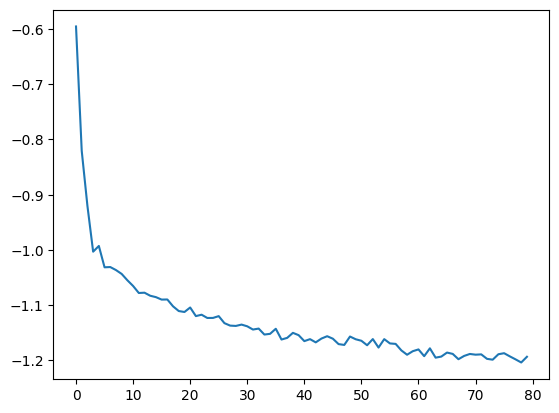

In [6]:
manager.display_evals('losses_batch', log_scale=False)

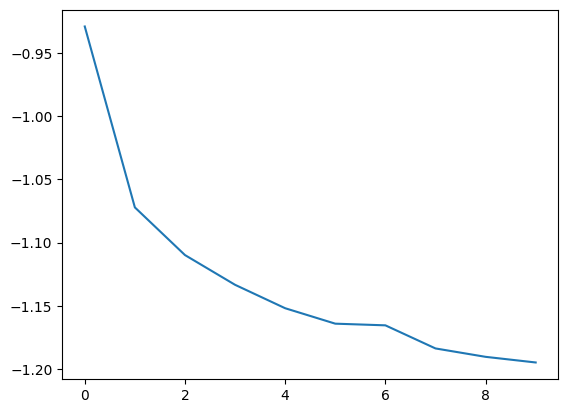

In [7]:
manager.display_evals('losses', log_scale=False)

In [ ]:
manager.display_evals('wass', log_scale=True)

In [ ]:
manager.display_evals('recall', log_scale=False)

In [ ]:
manager.display_evals('precision', log_scale=False)

As usual, $F_1$ score is:
$$ F_1 = 2\dfrac{\textrm{precision} \cdot \textrm{recall}}{\textrm{precision} + \textrm{recall}}$$ 

In [ ]:
manager.display_evals('f_1_pr', log_scale=False)

In [ ]:
for i in [-1]:
    display(manager.eval.evals['fig'][i])

# Reverse Sampling

## Inspect generated data trajectory - from noise to data distribution

In [4]:
gen_model = Gen.GenerationManager(model, pdmp, data)
gen_model.generate(1000)

ATTENTION: pdmp reverse_samlping, lin 330, only dim 2
ZigZag generation
True
torch.Size([1000, 1, 4])
torch.Size([101, 1000, 1, 4])


In [ ]:
# Look at the position of the particle through time
# print(gen_model.history.shape)
pos = gen_model.history.squeeze(-2)[:,2, :2]
# print(pos.shape) # squeeze: remove channel dimension
plt.plot(pos[:, 0], pos[:, 1], linestyle='-')
plt.grid(True)
plt.show()

We can now use our GenerationManager object to examine the generated data.

In [5]:
gen_model.generate(5000)

ATTENTION: pdmp reverse_samlping, lin 330, only dim 2
ZigZag generation, T = 10, N = 150
torch.Size([5000, 1, 4])
torch.Size([151, 5000, 1, 4])


* get animation

'./animation/check.mp4'

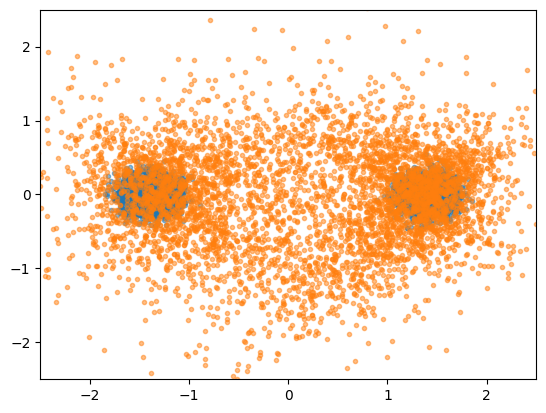

In [6]:
# Use Generation manager object to generate animation from the history of the data
gen_model.animation(generated_data_name = 'check')

* Get plot of the generated data.

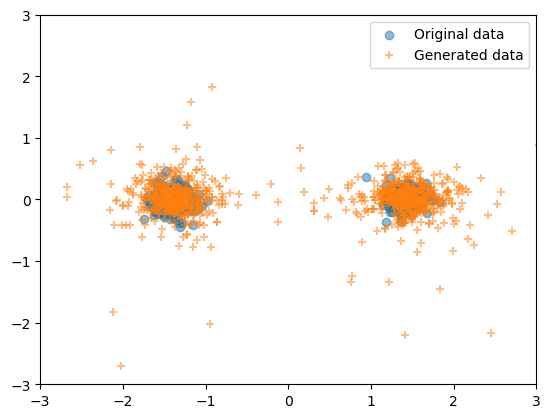

In [10]:
lims = 3
# gen_model.samples = chain[-1, :, :, :2].squeeze(-2) # get the last position of every sample, remove channel dimension
gen_model.get_plot(limit_nb_orig_data = 200, # number of original data to plot
                   xlim = (-lims, lims), ylim = (-lims, lims))